Using difference methods to solve dif eq boundary values

$$ Ax = b $$
\text{determinent is gone we are using gaussian eleimination, but doesn't use SIMD." SIMD" single instruction multiple data.}
\text{approximate A inverse such that A inverse is easily invertable (diagonalized). LU- Deposition A = Diag + LU}

$$A^{-1} = D + LU$$
$$(D - LU)x = b$$
$$x = D^{-1}(b - LUx)$$
\text{minimize LU or diagonaly dominant}
$$|a_{ii}|  \geq \sum_j|a_{ij}|$$
the ${ii}$ term is greater than the sum of the other terms in the row
 called the jacobian method
if $$\geq$$ marginally convergent -> precondition the matrix take thousands of iterations
if $$>$$ strictly convergent

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import time

def gaussian_upper_triangle(a, b):
    def exchange_rows(a, i, j):
        for k in range(len(a)):
            tmp = a[i][k]
            a[i][k] = a[j][k]
            a[j][k] = tmp
        return a
    
    
    C = np.column_stack((a, b))
    
    for i in range(len(C)):
        if C[i][i] == 0:
            if i < len(C) - 1:
                exchange_rows(C, i, i+1)
        else:
            diag = C[i][i]
            for k in range(i+1, len(C)):
                C[k] = C[k]*diag - C[i]*C[k][i]
    return C


def back_substitution(A, fixed = None):
    N = len(A)
    x = np.zeros(N)
    
    x[N-1] = A[N-1][N]/A[N-1][N-1]
    
    if fixed != None:
        for index in fixed:
            if index == N-1:
                x[N-1] = fixed[index]
                
    for i in range(N-2, -1, -1):
        s = 0
        for j in range(i+1, N):
            s += A[i][j]*x[j]
        s = A[i][N] - s
        s /= A[i][i]
        x[i] = s
        
        if fixed != None:
            for index in fixed:
                if index == i:
                    x[i] = fixed[index]
    return x


def gaussian_elimination(A, b, fixed=None):
    C = gaussian_upper_triangle(A, b)
    return back_substitution(C, fixed)

def jacobi(A, b, epsilon=1e-8, maxiter=5000, omega=1, fixed=None, debug=False):
    # avoid if inside for
    diag = np.diag(np.diag(A)) #diag twice?
    LU = A - diag
    x = np.zeros(len(b))
    diag_inverse = np.diag(1/np.diag(diag))
    if fixed == None:
        for i in range(maxiter):
            x_new = omega*np.dot(diag_inverse, b - np.dot(LU, x)) + (1 - omega) * x
            res = np.linalg.norm(x_new - x)
            if debug:  # remove later
                print(f'residue = {res}')
            if res < epsilon:
                return x_new
            x = x_new.copy()
        raise Exception(f'Jacobi did not converge in {maxiter} steps')
        #return x 
    else:
        for i in range(maxiter):
            for index in fixed:
                x[index] = fixed[index]
            x_new = omega*np.dot(diag_inverse, b - np.dot(LU, x)) + (1 - omega)*x
            for index in fixed:
                x_new[index] = fixed[index]
            res = np.linalg.norm(x_new - x)
            if debug:
                print(f'residue = {res}')
            if res < epsilon:
                return x_new
            x = x_new.copy()
        raise Exception(f'Jacobi did not converge in {maxiter} steps')
        #return x
                
if __name__ =="__main__":
    a1 = np.array([[2.0, 1.0, -1.0], [-3.0, -1.0, 2.0], [-2.0, 1.0, 2.0]])
    a2 = np.array([[2.0, 1.0, -1.0], [-3.0, -2.0, 2.0], [-0.5, 1.0, 2.0]])
    b = np.array([8, -11, -3])
    x = gaussian_elimination(a2, b)
    test = np.linalg.solve(a2, b)
    print(x, test)
    print(a2.dot(x), b)
    try:
        x_j = jacobi(a2, b)
        print(x_j)
    except Exception as e:
        print(e)
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    x = gaussian_elimination(a1, b)
    test = np.linalg.solve(a1, b)
    print(x, test)
    print(a1.dot(x), b)
    try:
        x_j = jacobi(a1, b)
        print(x_j)
    except Exception as e:
        print(e)
    try:
        x_j = jacobi(a1, b, omega=0.5)
        print(x_j)
    except Exception as e:
        print(e)

[ 5.  -1.5  0.5] [ 5.  -1.5  0.5]
[  8. -11.  -3.] [  8 -11  -3]
[ 4.99999997 -1.49999998  0.49999998]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
[ 2.  3. -1.] [ 2.  3. -1.]
[  8. -11.  -3.] [  8 -11  -3]
Jacobi did not converge in 5000 steps
[ 1.99999994  3.00000002 -1.00000008]


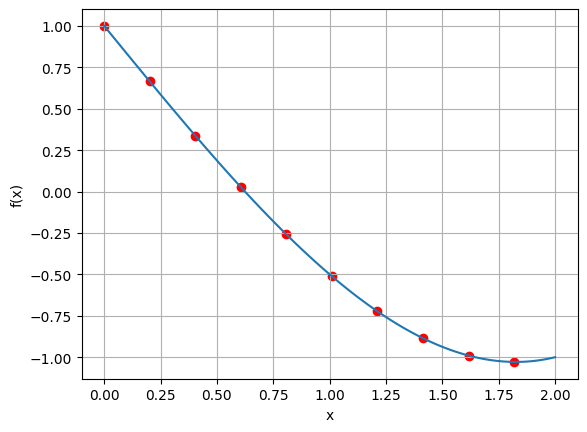

In [9]:
from linear_solver import jacobi
import time
import numpy as np
import matplotlib.pyplot as plt

# solve dif eq: ypp = x; x = [0, 2] y(0) = 1, and y(2) = -1
# y = x**3/6 - 3x + 1

def second_order_midpt(a, b, N, rhs, bc, methods='jacobi'):
    delta = (b - a)/ (N-1)
    A = np.zeros((N, N))
    b = np.zeros(N)
    x = np.zeros(N)
    for i in range(N):
        A[i][i] = -2
        try:
            A[i][i+1] = 1
        except Exception as e:
            pass
        if i > 0:
            A[i][i-1] = 1
        b[i] = delta * delta*rhs(i*delta)
        x[i] = a + delta*i
        
    if methods =='jacobi':
        begin_time = time.time()
        y = jacobi(A, b, fixed=bc, maxiter=30000)
        end_time = time.time()
        compute_time = (end_time - begin_time)*1000
    elif methods == 'gaussian_elimination':
        from linear_solver import gaussian_elimination
        begin_time = time.time()
        y = gaussian_elimination(A, b, fixed=bc)
        end_time = time.time()
        compute_time = (end_time - begin_time)*1000
    return x, y, compute_time

rhs = lambda x: x
a = 0.0
b = 2
N = 100
bc = {N-1: -1.0, 0: 1.0}

x_val, y_val, t = second_order_midpt(a, b, N, rhs, bc, methods='jacobi')
plt.scatter(x_val[::10], y_val[::10], color='red')
f = [x**3/6 - 5*x/3 + 1 for x in x_val]
plt.plot(x_val, f)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid()
plt.show()